In [ ]:
pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 9.1 MB/s eta 0:00:00


In [ ]:
import time
import torch
import math
import random
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt

from gym.wrappers import RecordVideo
from typing import List
from matplotlib import cm
from scipy.stats import beta
from collections import defaultdict
from IPython.display import clear_output
from IPython.display import Image

random.seed(111)
torch.manual_seed(111)

Воспроизведем эксперимент в уже знакомой среде Taxi-v3 с алгоритмом Q-learning.

In [ ]:
env = gym.make('Taxi-v3',
               max_episode_steps = None,
               autoreset = None,
               render_mode = 'ansi')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def animate(snapshots: list):
    for idx, frame in enumerate(snapshots):
        clear_output(wait = True)
        print(frame['frame'])
        print(f"Step: {idx + 1} \nState: {frame['state']}")
        print(f"Action: {frame['action']} \nReward: {frame['reward']}")
        time.sleep(1)

In [ ]:
def generate_policy(n_action: int,
                    epsilon: float):
    def eps_greedy(state: int,
                   Q: dict) -> int:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1 - epsilon
        action = torch.multinomial(probs, 1).item()

        return action

    return eps_greedy

In [ ]:
GAMMA = 1.0
N_EPISODE = 1000
ALPHA = 0.4
EPSILON = 0.1

In [ ]:
eps_greedy = generate_policy(env.action_space.n, EPSILON)

**Q-learning**

In [ ]:
def q_learning(env,
               gamma: float,
               n_episode: int,
               alpha: float):
    '''
    Obtain the optimal policy with off-policy Q-learning.

    Args:
        env - gym/gymnasium environment
        gamma - discount factor
        n_episode - total number of episodes
        alpha - learning rate
    Returns:
        Q - optimal Q-function
        policy - optimal policy
        length_episode - length of each episode in steps
        total_reward_episode - total reward for each episode
        snapshots - terminal-style text representation for each step
    '''
    Q = defaultdict(lambda: torch.zeros(env.action_space.n))
    length_episode, total_reward_episode, snapshots = [0] * n_episode, [0] * n_episode, []

    for episode in range(n_episode):
        state, _ = env.reset()
        done = False

        while not done:
            action = eps_greedy(state, Q)
            next_state, reward, done, _, _ = env.step(action)

            td_error = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_error

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if episode == n_episode - 1:
                snapshots.append({'frame': env.render(),
                                  'state': state,
                                  'action': action,
                                  'reward': reward})

            if done:
                break

            state = next_state

    policy = {}

    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()

    return Q, policy, length_episode, total_reward_episode, snapshots

In [ ]:
optimal_q, optimal_policy_q, length_episode_q, total_reward_episode_q, snapshots_q = q_learning(env, GAMMA, N_EPISODE, ALPHA)

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.plot(length_episode_q)
plt.title('Q-learning \nДлительность эпизода по мере обучения',
          fontsize = 14)
plt.xlabel('Эпизоды',
           fontsize = 12)
plt.ylabel('Длительность эпизода',
           fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.plot(total_reward_episode_q)
plt.title('Q-learning \nВознаграждение за эпизод с течением времени',
          fontsize = 14)
plt.xlabel('Эпизоды',
           fontsize = 12)
plt.ylabel('Полное вознаграждение',
           fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
animate(snapshots_q)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 13 
State: 16
Action: 5 
Reward: 20


Q-learning использует одну функцию ценности Q(s,a), которая оценивает ценность пары state-action. На каждом шаге обновляется значение Q(s,a) на основе наблюдаемого вознаграждения и оценки максимального значения Q для следующего состояния.

Double Q-learning использует две независимые функции ценности - Q1(s,a) и Q2(s,a). Идея состоит в том, чтобы уменьшить переоценку значений функции Q, которая возникает при классическом Q-learning. Для этого одна функция Q используется для выбора действий, а другая - для оценки максимального значения Q для следующего состояния.

Основные отличия от классического Q-learning:
1. Используются два отдельных тензора Q1 и Q2 для хранения значений Q.
2. Выбор между обновлением Q1 или Q2 происходит случайным образом с равной вероятностью.
3. Для выбора действия используется сумма Q1 + Q2.
4. Для вычисления оптимальной стратегии используется сумма Q1 + Q2.


**Задание 1**:

Реализуйте обновление Q для двух независимых функций ценности и сравните длительность эпизода и вознаграждение с течением времени с классическим алгоритмом.

**Double Q-learning**

In [ ]:
def double_q_learning(env,
                      gamma: float,
                      n_episode: int,
                      alpha: float):
    '''
    Obtain the optimal policy with off-policy Double Q-learning.

    Args:
        env - gym/gymnasium environment
        gamma - discount factor
        n_episode - total number of episodes
        alpha - learning rate
    Returns:
        Q - optimal Q-function
        policy - optimal policy
        length_episode - length of each episode in steps
        total_reward_episode - total reward for each episode
        snapshots - terminal-style text representation for each step
    '''
    Q1 = torch.zeros(env.observation_space.n, env.action_space.n)
    Q2 = torch.zeros(env.observation_space.n, env.action_space.n)
    length_episode, total_reward_episode, snapshots = [0] * n_episode, [0] * n_episode, []

    def get_max_q_action(Q, next_state):
      return torch.max(Q[next_state])

    for episode in range(n_episode):
        state, _ = env.reset()
        done = False

        while not done:
            action = eps_greedy(state, Q1 + Q2)
            next_state, reward, done, _, _ = env.step(action)

            ### YOUR CODE HERE
            ### YOUR CODE HERE
            ### YOUR CODE HERE
            q_func = Q1 if bool(random.getrandbits(1)) else Q2
            other_q_func = Q1 if q_func is Q2 else Q2

            max_q_action = torch.max(q_func[next_state])
            prev_q_val = q_func[state][action]

            q_func[state][action] = (1 - alpha) * prev_q_val + alpha * (reward + gamma * other_q_func[next_state][max(0, min(max_q_action.long(), 5))])

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if episode == n_episode - 1:
                snapshots.append({'frame': env.render(),
                                  'state': state,
                                  'action': action,
                                  'reward': reward})

            if done:
                break

            state = next_state

    policy = {}
    Q = Q1 + Q2

    for state in range(env.observation_space.n):
        policy[state] = torch.argmax(Q[state]).item()

    return Q, policy, length_episode, total_reward_episode, snapshots

In [ ]:
optimal_dq, optimal_policy_dq, length_episode_dq, total_reward_episode_dq, snapshots_dq = double_q_learning(env, GAMMA, N_EPISODE, ALPHA)

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.plot(length_episode_dq)
plt.title('Double Q-learning \nДлительность эпизода по мере обучения',
          fontsize = 14)
plt.xlabel('Эпизоды',
           fontsize = 12)
plt.ylabel('Длительность эпизода',
           fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.plot(total_reward_episode_dq)
plt.title('Double Q-learning \nВознаграждение за эпизод с течением времени',
          fontsize = 14)
plt.xlabel('Эпизоды',
           fontsize = 12)
plt.ylabel('Полное вознаграждение',
           fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
animate(snapshots_dq)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Step: 10 
State: 97
Action: 5 
Reward: 20


**Coin flip: value and policy iteration**

Представим, что мы играем в следующую азартную игру: есть несимметричная монетка с шансом выпадения орла **head_prob**; каждый раунд мы делаем ставку на выпадение последнего, и в случае, если орел действительно выпал, мы получаем ту сумму, которую поставили, в противном случае - теряем свою ставку. Игра продолжается либо до выигрыша определенной суммы **win_condition**, либо до опустошения наших карманов.

Наибольшую сложность в RL представляет формулировка задачи в виде MDP. В нашем случае стратегия заключается в переходе от текущего состояния state к новому win_condition, делая ставки action. Оптимальная стратегия максимизирует вероятность выиграть игру.

In [ ]:
head_prob = 0.33
win_condition = 100
n_state = win_condition + 1
rewards = torch.zeros(n_state)
rewards[-1] = 1

В контексте нашей игры **state** - это наш капитал в условных единицах. Всего имеется (win_condition + 1) состояний: 0, 1, 2, ..., win_condition.

**Reward** в случае достижения состояния win_condition равен 1, в противном случае - 0.

**Action** - это наша ставка в условных единицах. В состоянии state допустимы следующие ставки 1, 2, 3, ..., min(state, win_condition - state). Это следует иметь в виду при решении уравнения оптимальности Беллмана.

В зависимости от вероятности выпадения орла head_prob мы попадаем в следующее состояние: при выборе действия action в состоянии state мы попадаем в состояние (state + action) с вероятностью head_prob и в состояние (state - action) с вероятностью (1 - head_prob).

Игра завершается в состояниях 0 или state >= win_condition.

Зададим параметры алгоритма:

In [ ]:
GAMMA = 1
THRESHOLD = 1e-10

Коэффициент дисконтирования равен 1, т.к в нашем окружении обесценивания нет. Порог задан малым числом, поскольку мы ожидаем, что ценности действий будут принимать малые значения (reward за все действия, кроме перехода в последнее состояние, нулевой).

Зададим параметры нашей среды:

In [ ]:
env = {'win_condition': win_condition,
       'head_prob': head_prob,
       'rewards': rewards,
       'n_state': n_state}

Решим задачу с помощью алгоритма **итерации по ценности**.

Подготовим функцию для вычисления оптимальных ценностей, применяя алгоритм итерации по ценности.


**Задание 2**:

Для каждого возможного действия action в текущем состоянии state вычислите ожидаемое значение ценности для этого действия action. Оно вычисляется как сумма двух слагаемых: первое слагаемое соответствует случаю, когда выпадает орел, а второе - случаю, когда выпадает решка.

In [ ]:
def value_iteration(env: dict,
                    gamma: float,
                    threshold: float) -> torch.Tensor:
    '''
    Value iteration algorithm.

    Args:
        env - coin flip environment
        gamma - discount factor
        threshold - stop as soon as the values for all states are less than the threshold value
    Returns:
        V - values of the optimal policy for the given env
    '''
    head_prob, n_state, win_condition = env['head_prob'], env['n_state'], env['win_condition']
    V = torch.zeros(n_state)

    while True:
        V_temp = torch.zeros(n_state)

        for state in range(1, win_condition):
            v_actions = torch.zeros(min(state, win_condition - state) + 1)

            for action in range(1, min(state, win_condition - state) + 1):

                ### YOUR CODE HERE
                ### YOUR CODE HERE
                ### YOUR CODE HERE
                v_actions[action] = head_prob * (rewards[state + action] + gamma * V[state + action])
                v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V[state - action])

            V_temp[state] = torch.max(v_actions)

        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()

        if max_delta <= threshold:
            break

    return V

Подготовим функцию для вычисления оптимальной стратегии по оптимальным ценностям.

**Задание 3**:

Для каждого возможного действия action в текущем состоянии state вычислите его ожидаемое значение ценности. Оно вычисляется как сумма двух слагаемых: первое слагаемое соответствует случаю, когда выпадает орел, а второе - случаю, когда выпадает решка. Вместо значений из V используйте оптимальные значения из V_optimal.

In [ ]:
def extract_optimal_policy(env: dict,
                           V_optimal: torch.Tensor,
                           gamma: float) -> torch.Tensor:
    '''
    Computation of the optimal policy based on optimal values.

    Args:
        env - coin flip environment
        V_optimal - optimal values
        gamma - discount factor
    Returns:
        optimal_policy - optimal policy
    '''
    head_prob, n_state, win_condition = env['head_prob'], env['n_state'], env['win_condition']
    optimal_policy = torch.zeros(win_condition).int()

    for state in range(1, win_condition):
        v_actions = torch.zeros(n_state)

        for action in range(1, min(state, win_condition - state) + 1):

            ### YOUR CODE HERE
            ### YOUR CODE HERE
            ### YOUR CODE HERE
            v_actions[action] = head_prob * (rewards[state + action] + gamma * V_optimal[state + action])
            v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V_optimal[state - action])


        optimal_policy[state] = torch.argmax(v_actions)

    return optimal_policy

Вычислим оптимальные ценности и оптимальную стратегию, замерив при этом время на решение MDP итерацией по ценности:


In [ ]:
start_time = time.time()
V_optimal = value_iteration(env, GAMMA, THRESHOLD)
optimal_policy = extract_optimal_policy(env, V_optimal, GAMMA)
end_time = time.time()

print(f'It takes {round(end_time - start_time, 3)} seconds to solve MDP.')
print(f'\nOptimal values:\n{V_optimal}')
print(f'\nOptimal policy:\n{optimal_policy}')

It takes 6.1 seconds to solve MDP.

Optimal values:
tensor([0.0000e+00, 5.2613e-04, 1.5943e-03, 3.2511e-03, 4.8313e-03, 6.8715e-03,
        9.8519e-03, 1.2578e-02, 1.4640e-02, 1.7427e-02, 2.0823e-02, 2.5181e-02,
        2.9854e-02, 3.6290e-02, 3.8115e-02, 4.0541e-02, 4.4364e-02, 4.7613e-02,
        5.2808e-02, 6.0251e-02, 6.3099e-02, 6.7838e-02, 7.6305e-02, 8.1388e-02,
        9.0467e-02, 1.0890e-01, 1.0997e-01, 1.1214e-01, 1.1550e-01, 1.1871e-01,
        1.2285e-01, 1.2890e-01, 1.3444e-01, 1.3862e-01, 1.4428e-01, 1.5118e-01,
        1.6002e-01, 1.6951e-01, 1.8258e-01, 1.8629e-01, 1.9121e-01, 1.9897e-01,
        2.0557e-01, 2.1612e-01, 2.3123e-01, 2.3701e-01, 2.4663e-01, 2.6382e-01,
        2.7414e-01, 2.9258e-01, 3.3000e-01, 3.3107e-01, 3.3324e-01, 3.3660e-01,
        3.3981e-01, 3.4395e-01, 3.5000e-01, 3.5554e-01, 3.5972e-01, 3.6538e-01,
        3.7228e-01, 3.8112e-01, 3.9061e-01, 4.0368e-01, 4.0739e-01, 4.1231e-01,
        4.2007e-01, 4.2667e-01, 4.3722e-01, 4.5233e-01, 4.5811e-01, 

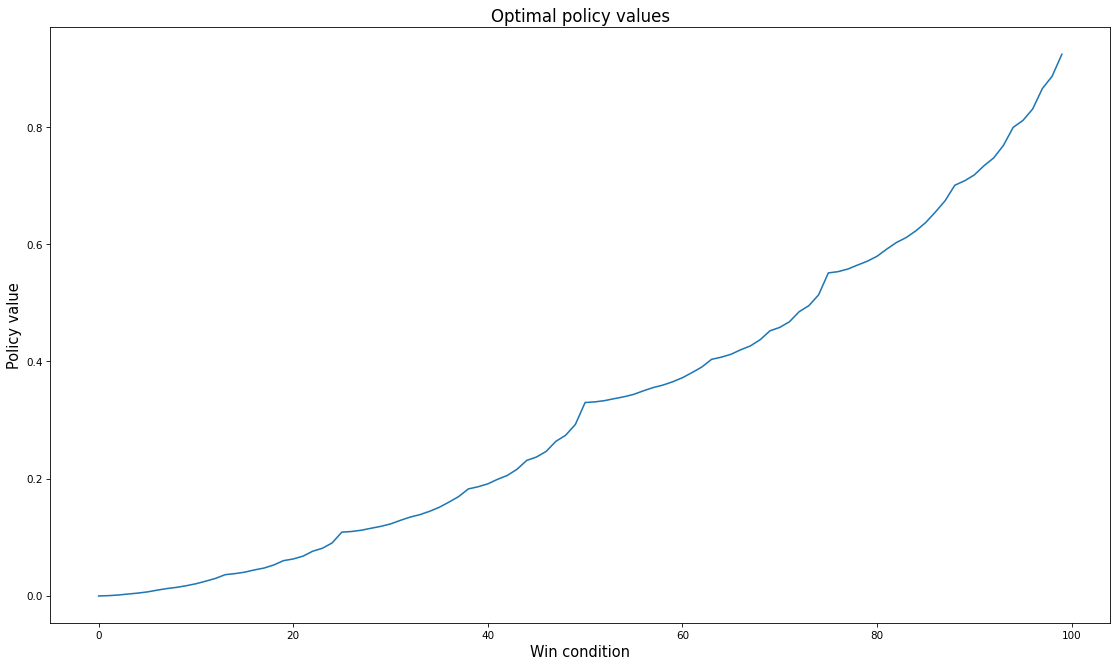

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.plot(V_optimal[:win_condition].numpy())
plt.title('Optimal policy values',
           fontsize = 16)
plt.xlabel('Win condition',
           fontsize = 14)
plt.ylabel('Policy value',
           fontsize = 14)
plt.tight_layout()
plt.show()

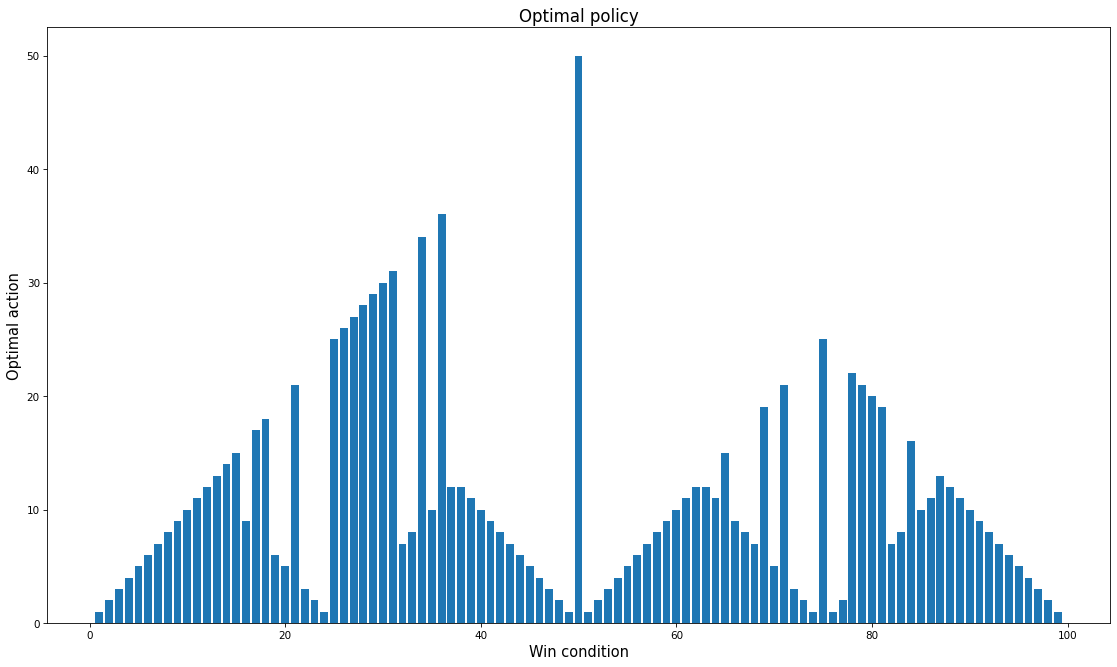

In [ ]:
plt.figure(figsize = (15, 9),
            dpi = 75)
plt.bar(range(1, win_condition), optimal_policy[1:win_condition].numpy())
plt.title('Optimal policy',
           fontsize = 16)
plt.xlabel('Win condition',
           fontsize = 14)
plt.ylabel('Optimal action',
           fontsize = 14)
plt.tight_layout()
plt.show()

Теперь решим задачу с помощью алгоритма **итерации по стратегиям**.

Подготовим функцию, которая вычисляет ценности при следовании данной стратегии.

**Задание 4**:

 Для каждого состояния state извлеките действие action из стратегии policy. Вычислите обновленную оценку значения ценности состояния state на основе вероятности выпадения орла head_prob, текущих оценок значений V, коэффициента дисконтирования gamma и вознаграждений rewards для следующих состояний.


In [ ]:
def policy_evaluation(env: dict,
                      policy: torch.Tensor,
                      gamma: float,
                      threshold: float) -> torch.Tensor:
    '''
    Policy evaluation.

    Args:
        env - coin flip environment
        policy - policy tensor containing actions taken for individual state
        gamma - discount factor
    Returns:
        V - values of the given policy
    '''
    head_prob, n_state, win_condition = env['head_prob'], env['n_state'], env['win_condition']
    V = torch.zeros(n_state)

    while True:
        V_temp = torch.zeros(n_state)

        for state in range(1, win_condition):

            ### YOUR CODE HERE
            ### YOUR CODE HERE
            ### YOUR CODE HERE
            V_temp[state] = head_prob * (rewards[state + policy[state]] + gamma * V[state + policy[state]])
            V_temp[state] += (1 - head_prob) * (rewards[state - policy[state]] + gamma * V[state - policy[state]])


        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()

        if max_delta <= threshold:
            break

    return V

Построим новую стратегию по полученным ценностям, применяя уравнение оптимальности Беллмана.

**Задание 5**:

Для каждого действия action вычислите его оценку значения ценности на основе вероятности выпадения орла head_prob, текущих оценок значений V, коэффициента дисконтирования gamma и вознаграждений rewards для следующих состояний.


In [ ]:
def policy_improvement(env: dict,
                       V: torch.Tensor,
                       gamma: float) -> torch.Tensor:
    '''
    Compute an improved policy based on the values.

    Args:
        env - coin flip environment
        V - policy values
        gamma - discount factor
    Returns:
        policy - the policy
    '''
    head_prob, n_state, win_condition = env['head_prob'], env['n_state'], env['win_condition']
    policy = torch.zeros(n_state).int()

    for state in range(1, win_condition):
        v_actions = torch.zeros(min(state, win_condition - state) + 1)

        for action in range(1, min(state, win_condition - state) + 1):

            ### YOUR CODE HERE
            ### YOUR CODE HERE
            ### YOUR CODE HERE
            v_actions[action] = head_prob * (rewards[state + action] + gamma * V[state + action])
            v_actions[action] += (1 - head_prob) * (rewards[state - action] + gamma * V[state - action])

        policy[state] = torch.argmax(v_actions)

    return policy

Свяжем воедино оценку и улучшение стратегии:

In [ ]:
def policy_iteration(env: dict,
                     gamma: float,
                     threshold: float) -> (torch.Tensor, torch.Tensor):
    '''
    Solve the problem using policy iteration aglorithm.

    Args:
        env - coin flip environment
        gamma - discount factor
        threshold - stop as soon as the values for all states are less than the threshold value
    Returns:
        V - values of the optimal policy for the given env
        policy_improved - optimal policy for the given env
    '''
    n_state = env['n_state']
    policy = torch.zeros(n_state).int()

    while True:
        V = policy_evaluation(env, policy, gamma, threshold)
        policy_improved = policy_improvement(env, V, gamma)

        if torch.equal(policy_improved, policy):
            return V, policy_improved

        policy = policy_improved

Вычислим оптимальные ценности и оптимальную стратегию, замерив при этом время на решение MDP итерацией по стратегиям:


In [ ]:
start_time = time.time()
V_optimal, optimal_policy = policy_iteration(env, GAMMA, THRESHOLD)
end_time = time.time()

print(f'It takes {round(end_time - start_time, 3)} seconds to solve MDP.')
print(f'\nOptimal values:\n{V_optimal}')
print(f'\nOptimal policy:\n{optimal_policy}')

It takes 6.761 seconds to solve MDP.

Optimal values:
tensor([0.0000e+00, 5.2613e-04, 1.5943e-03, 3.2511e-03, 4.8313e-03, 6.8715e-03,
        9.8519e-03, 1.2578e-02, 1.4640e-02, 1.7427e-02, 2.0823e-02, 2.5181e-02,
        2.9854e-02, 3.6290e-02, 3.8115e-02, 4.0541e-02, 4.4364e-02, 4.7613e-02,
        5.2808e-02, 6.0251e-02, 6.3099e-02, 6.7838e-02, 7.6305e-02, 8.1388e-02,
        9.0467e-02, 1.0890e-01, 1.0997e-01, 1.1214e-01, 1.1550e-01, 1.1871e-01,
        1.2285e-01, 1.2890e-01, 1.3444e-01, 1.3862e-01, 1.4428e-01, 1.5118e-01,
        1.6002e-01, 1.6951e-01, 1.8258e-01, 1.8629e-01, 1.9121e-01, 1.9897e-01,
        2.0557e-01, 2.1612e-01, 2.3123e-01, 2.3701e-01, 2.4663e-01, 2.6382e-01,
        2.7414e-01, 2.9258e-01, 3.3000e-01, 3.3107e-01, 3.3324e-01, 3.3660e-01,
        3.3981e-01, 3.4395e-01, 3.5000e-01, 3.5554e-01, 3.5972e-01, 3.6538e-01,
        3.7228e-01, 3.8112e-01, 3.9061e-01, 4.0368e-01, 4.0739e-01, 4.1231e-01,
        4.2007e-01, 4.2667e-01, 4.3722e-01, 4.5233e-01, 4.5811e-01

Мы решили задачу нашу задачу двумя методами: итерацией по ценности и итерацией по стратегиям. В данном случае алгоритм итерации по стратегиям сходится (по крайней мере в теории должен быть) быстрее алгоритма итерации по ценности - для MDP с большим количеством действий алгоритм итерации по стратегиям оказывается эффективнее.


Проверим, так ли оптимальна наша стратегия. Сравним вероятности выигрыша, следуя оптимальной стратегии, со случайной и константной стратегией на протяжении n_episode, имея cash условных единиц.

In [ ]:
cash = 50
n_episode = 5000

In [ ]:
def run(head_prob: float,
        cash: int,
        optimal_policy: torch.Tensor,
        win_condition: int,
        random: bool = False) -> int:

    while cash:
        if random:
            bet = torch.randint(1, cash + 1, (1,)).item()
        elif torch.is_tensor(optimal_policy):
            bet = optimal_policy[cash].item()
        else:
            bet = 1

        if torch.rand(1).item() < head_prob:
            cash += bet

            if cash >= win_condition:
                return 1

        else:
            cash -= bet

    return 0

In [ ]:
rewards_const, rewards_random, rewards_opt = [], [], []

for _ in range(n_episode):
    reward_const = run(head_prob, cash, None, win_condition, False)
    reward_random = run(head_prob, cash, None, win_condition, True)
    reward_opt = run(head_prob, cash, optimal_policy, win_condition, False)
    rewards_const.append(reward_const)
    rewards_random.append(reward_random)
    rewards_opt.append(reward_opt)

При корректных расчетах среднее вознаграждение, полученное при следовании оптимальной стратегии, должно в ~2 превосходить полученное при следовании случайной стратегии.

In [ ]:
print(f'Avg total reward under the constant policy over {n_episode} episodes:', sum(rewards_const) / n_episode)
print(f'Avg total reward under the random policy over {n_episode} episodes:', round(sum(rewards_random) / n_episode, 2))
print(f'Avg total reward under the optimal policy over {n_episode} episodes:', round(sum(rewards_opt) / n_episode, 2))

Avg total reward under the constant policy over 5000 episodes: 0.0
Avg total reward under the random policy over 5000 episodes: 0.14
Avg total reward under the optimal policy over 5000 episodes: 0.34
